📂 读取: ktss.bib
✅ 有效文献: 87（摘要≥30）


,title,year
0,{Digital government transformation: A case ill...,2018
1,{Big Data-Driven Public Policy Decisions: Tran...,2023
2,{Big Data Analytics: A Catalyst for Digital Tr...,2023
3,{Oecd Countries' Experience in Transformation ...,2024
4,{Building Collaborative Digital Government Sys...,2002



🔧 构建 TF-IDF（1-3gram）...
✅ TF-IDF 维度: (87, 1664)

🧪 Seed-features 命中诊断（hits + sample）
  - Public service delivery: hits=14 | ['access', 'accessibility', 'citizen', 'citizens', 'delivery', 'experience', 'provision', 'public service', 'quality', 'satisfaction', 'service delivery', 'service provision']
  - Government organizational structure: hits=12 | ['collaboration', 'coordination', 'governance', 'horizontal', 'integration', 'inter-agency', 'interagency', 'network', 'organization', 'organizational', 'silo', 'structure']
  - Government operating logic and processes: hits=10 | ['automated', 'automation', 'business', 'case', 'operating', 'procedures', 'process', 'processes', 'standard', 'streamlined']
  - Departmental responsibilities and administrative authority: hits=18 | ['accountability', 'administrative', 'bureaucracy', 'bureaucratic', 'control', 'decision', 'decision making', 'departmental', 'discretion', 'functional', 'level', 'making']
  - Leadership: hits=11 | ['capacity', 'commi

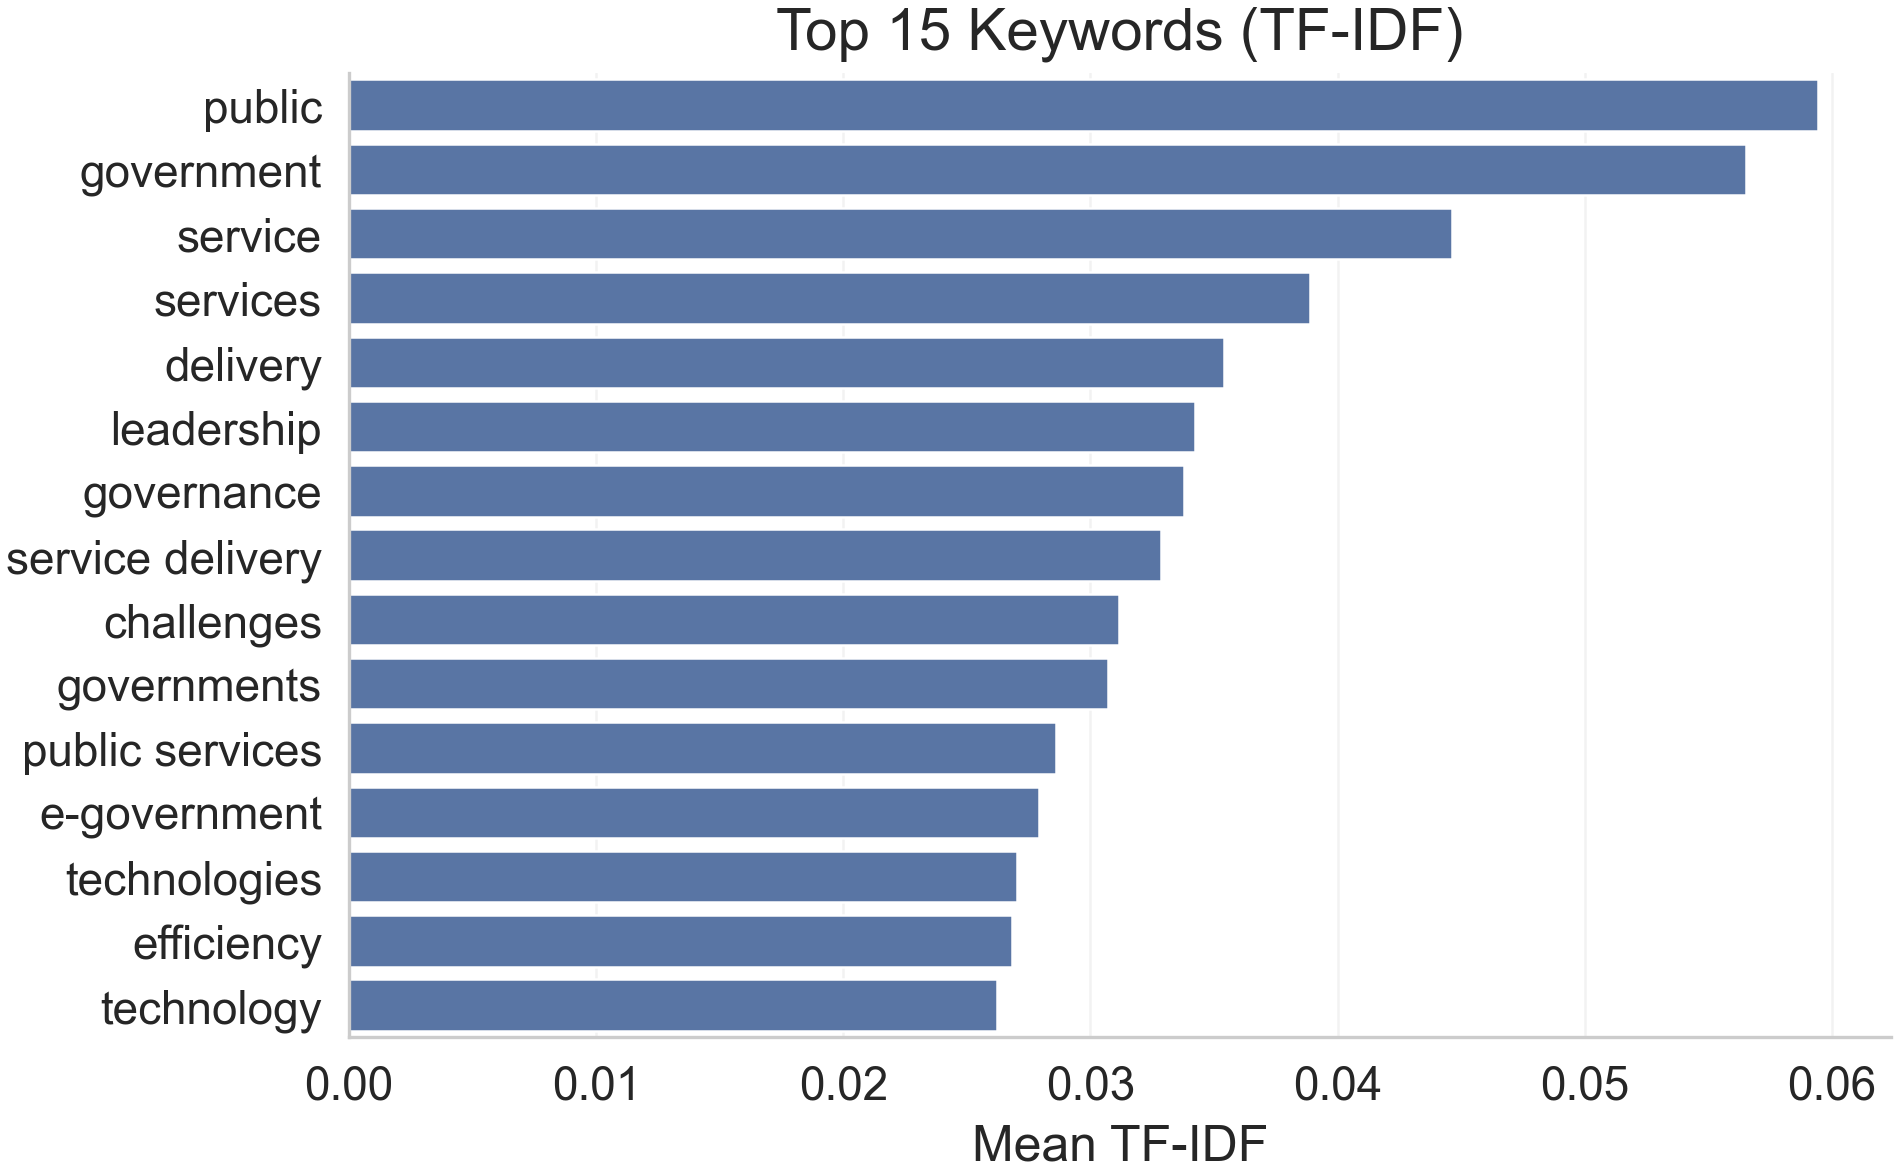


🧠 NMF：n_topics=10 (specificity-weighted boost)
✅ Seed boosting done: boosted_cols=64
----------------------------------------------------------------------
Topic 1: service delivery, delivery, public service, citizens, citizen, service, accessibility, access, public, public service delivery, satisfaction, services
Topic 2: transformational, leadership, transformational leadership, organizational, agility, adaptive, level, influence, vision, network, strategy, technological
Topic 3: making, processes, decision making, decision, discretion, automation, experience, administrative, quality, support, policy, solutions
Topic 4: role, role e-governance, including, inter-agency, collaboration, leadership, e-government, countries, examines, e-governance, capacity, service
Topic 5: administrative, organizational, collaboration, level, case, integration, rights, processes, institutional, information, inter-agency, boundaries
Topic 6: process, power, pandemic, public, state, vision, citizens, dec

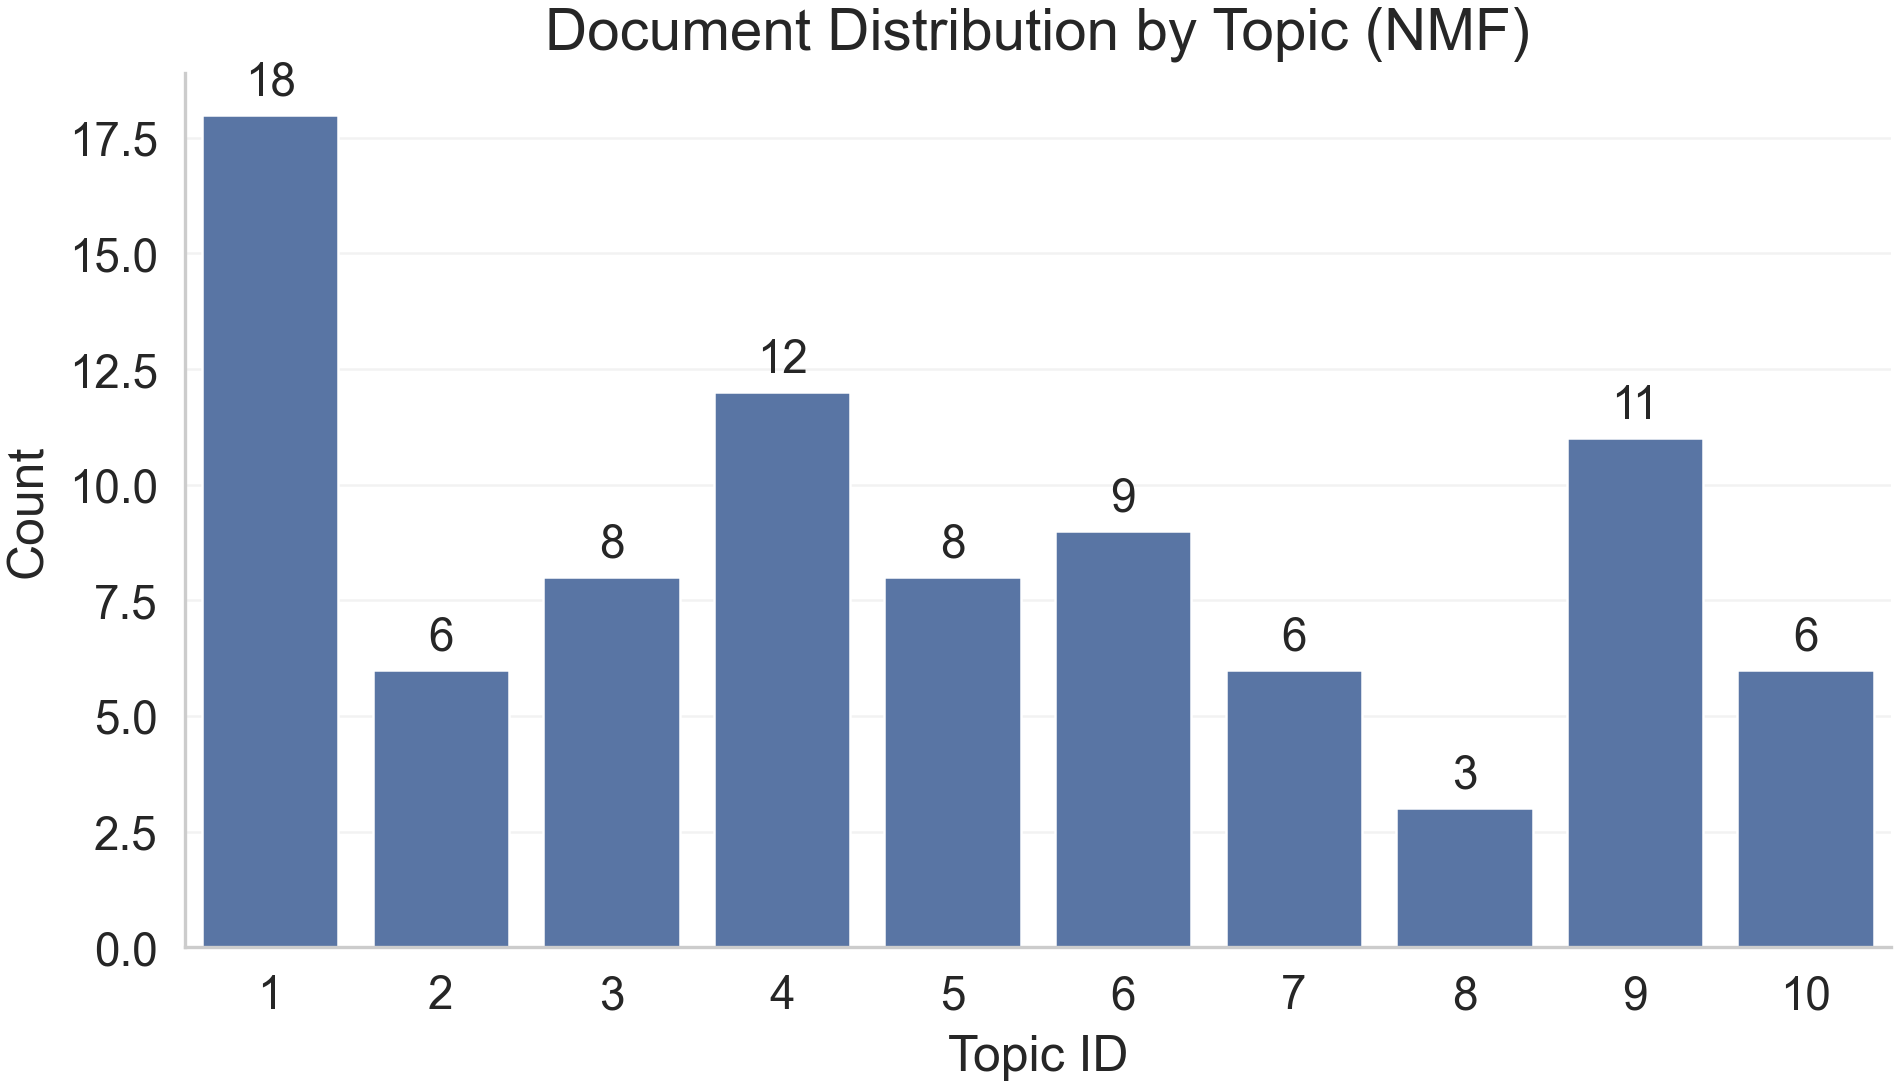


🧩 Topic -> Dimension（weighted overlap, ensure_all_dims=True）


,Topic_ID,Mapped_Dimension,WeightedOverlap,Top_terms_sample
2,3,Departmental responsibilities and administrati...,7.0,"making, processes, decision making, decision, ..."
9,10,Departmental responsibilities and administrati...,6.0,"mechanisms, roles, provision, service provisio..."
8,9,Government operating logic and processes,5.0,"accountability, business, leadership, organiza..."
7,8,Government operating logic and processes,4.0,"standard, departmental, rights, business, feat..."
4,5,Government organizational structure,7.5,"administrative, organizational, collaboration,..."
5,6,Government organizational structure,4.5,"process, power, pandemic, public, state, visio..."
1,2,Leadership,7.5,"transformational, leadership, transformational..."
6,7,Leadership,4.5,"bureaucracy, management, bureaucratic, organiz..."
3,4,Leadership,3.5,"role, role e-governance, including, inter-agen..."
0,1,Public service delivery,11.0,"service delivery, delivery, public service, ci..."



✅ Dimension counts (show zeros):
Public service delivery                                       18
Government organizational structure                           17
Government operating logic and processes                      14
Departmental responsibilities and administrative authority    14
Leadership                                                    24
Unmapped                                                       0
Name: Dimension, dtype: Int64

✅ #Topics mapped into each dimension:
Public service delivery                                       1
Government organizational structure                           2
Government operating logic and processes                      2
Departmental responsibilities and administrative authority    2
Leadership                                                    3
Unmapped                                                      0
dtype: int64


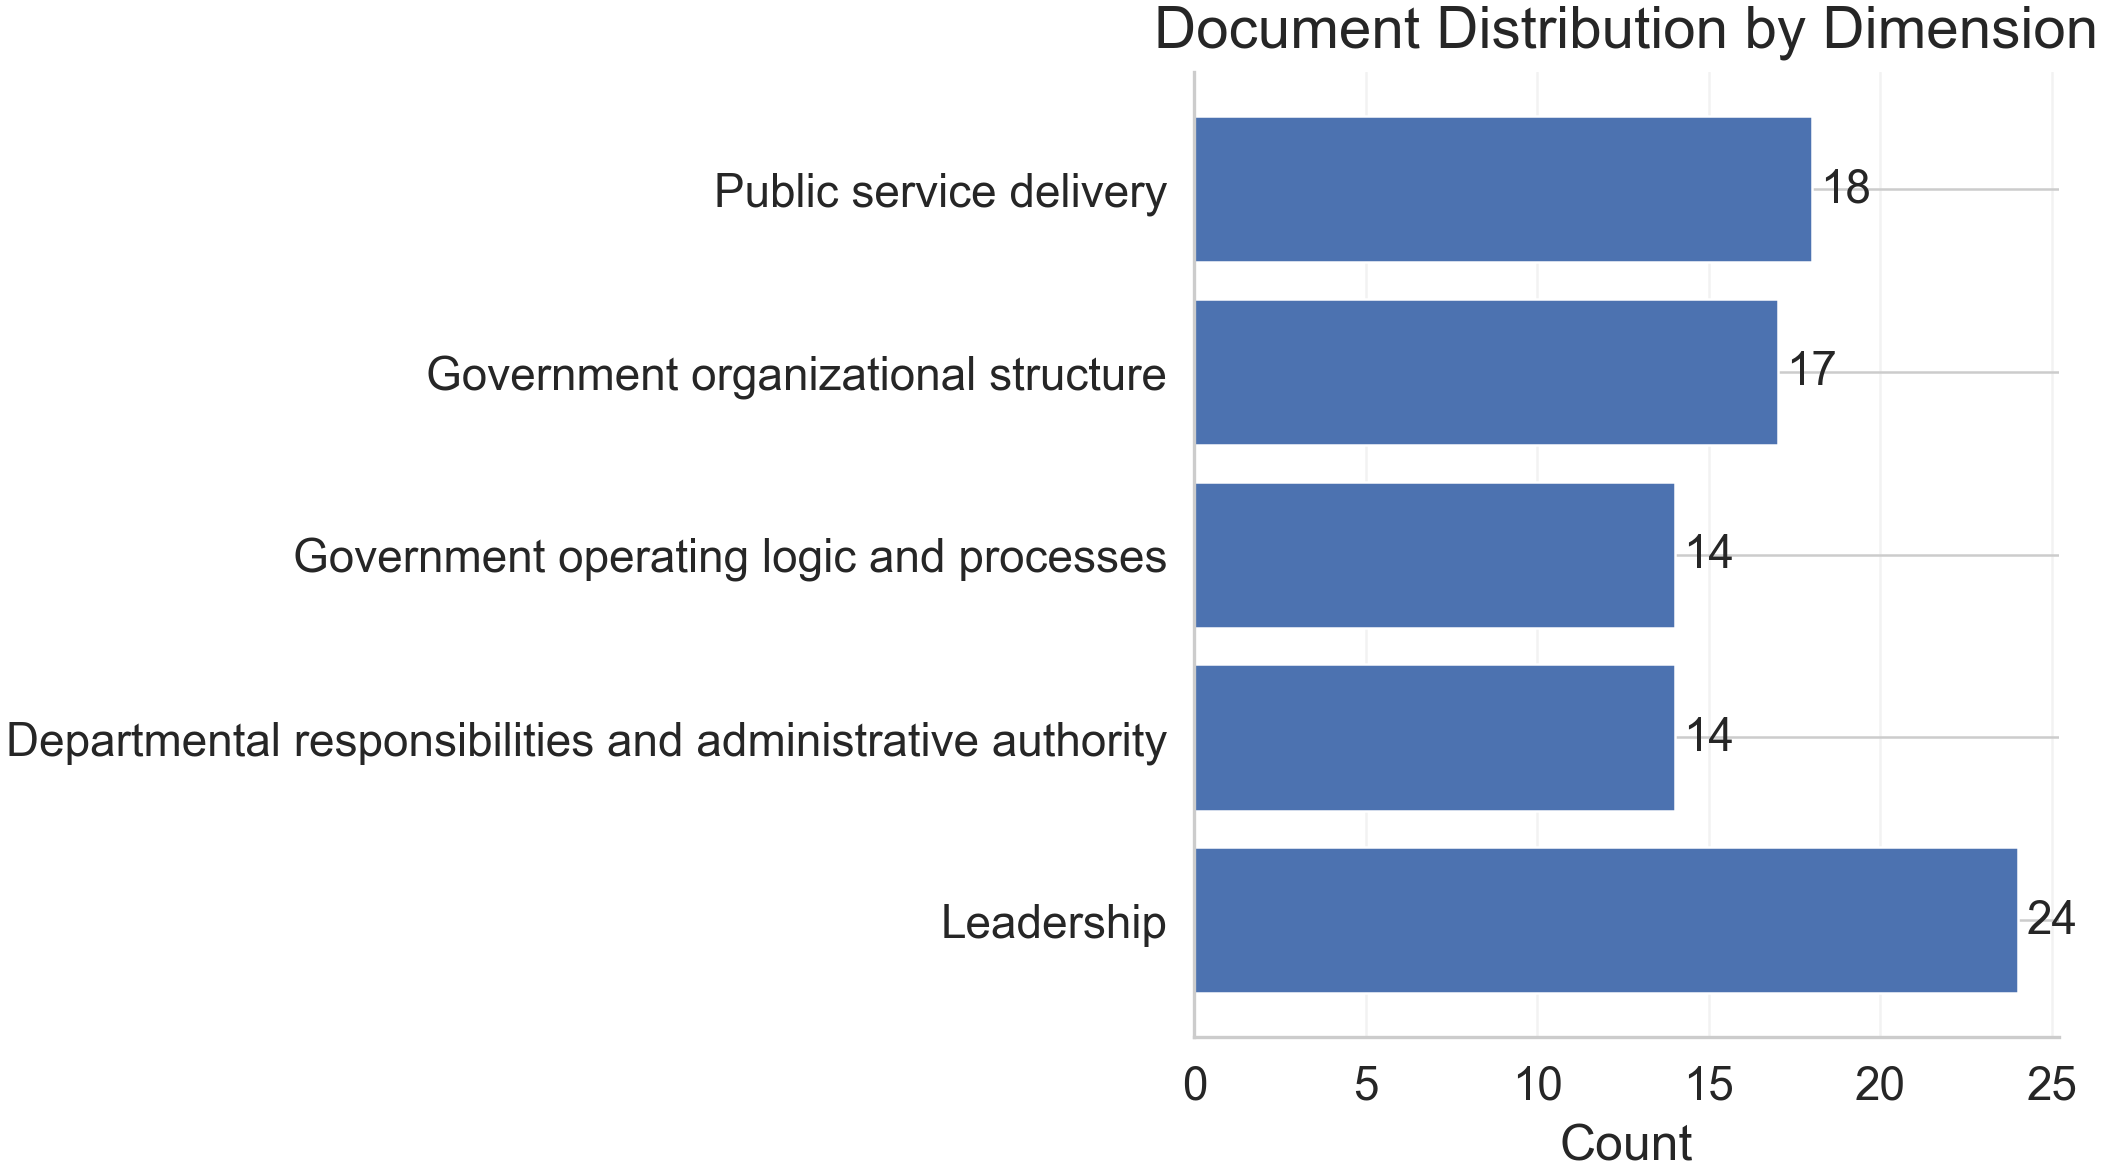


📝 Key sentence sample:


,title,Objective,Method,Result
0,{Digital government transformation: A case ill...,We investigate how digitalization of public se...,,
1,{Big Data-Driven Public Policy Decisions: Tran...,"Most studies focus on e-government, e-governan...","However, this article aims to explore the pote...","Most studies focus on e-government, e-governan..."
2,{Big Data Analytics: A Catalyst for Digital Tr...,,,The benefits of using BDA in e-Government are ...



💾 Saved: analysis_report.csv


In [3]:
# ===========================
# Public Management Literature Analyzer (BIB/RIS)
# - TF-IDF (1-3gram) + seed-features aligned with vectorizer analyzer
# - Specificity-weighted seeds: weight = 1 / (#dims sharing the token)
# - NMF topic modeling (n_topics can be > 5)
# - Many-to-one mapping with ensure_all_dims
# ===========================

import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    sns = None

# ========== optional parsers + display ==========
bibtexparser = None
rispy = None
try:
    import bibtexparser
except ImportError:
    pass

try:
    import rispy
except ImportError:
    pass

try:
    from IPython.display import display
except ImportError:
    def display(x):
        print(x)

# ===========================
# ✅ FIGURE-ONLY MODIFICATIONS START
# ===========================

# Seaborn theme for publication
if sns is not None:
    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="Arial",
        font_scale=1.1
    )

# Matplotlib rcParams for journal-ready figures
plt.rcParams.update({
    "font.family": "Arial",
    "font.sans-serif": ["Arial"],     # force Arial (if not installed, matplotlib will fallback)
    "axes.unicode_minus": False,

    # Vector font embedding (important for journal PDFs)
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    # Figure export defaults
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,

    # Clean spines
    "axes.spines.top": False,
    "axes.spines.right": False,

    # Line widths
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.6,

    # Typography (paper-like)
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
})

def _pub_ax(ax, grid_axis="x"):
    """Lightweight publication styling for an axis."""
    ax.set_axisbelow(True)
    ax.grid(True, axis=grid_axis, alpha=0.25)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
    ax.tick_params(axis="both", width=0.8, length=3)

def _annotate_barh(ax, pad=0.15, fmt="{:d}"):
    """Annotate horizontal bar values."""
    for p in ax.patches:
        w = p.get_width()
        if np.isnan(w):
            continue
        ax.text(w + pad, p.get_y() + p.get_height()/2, fmt.format(int(round(w))),
                va="center", ha="left", fontsize=11)

def _annotate_bar(ax, pad=0.15, fmt="{:d}"):
    """Annotate vertical bar values."""
    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h):
            continue
        ax.text(p.get_x() + p.get_width()/2, h + pad, fmt.format(int(round(h))),
                va="bottom", ha="center", fontsize=11)

# ===========================
# ✅ FIGURE-ONLY MODIFICATIONS END
# ===========================


# ========== stopwords (avoid putting 'public/government/governance' here) ==========
PM_STOP_WORDS = set(ENGLISH_STOP_WORDS)
PM_STOP_WORDS.update([
    "study","paper","article","research","review","result","results","finding","findings",
    "method","methods","methodology","approach","approaches","model","models","framework",
    "analysis","data","dataset","experiment","experimental","significant","demonstrate",
    "show","shown","present","provide","provides","discuss","discussion","conclusion",
    "based","use","used","using","new","novel","various","different",
    "digital","transformation","implementation","sector",
    "egovernment","electronic"
])
PM_STOP_WORDS = sorted(PM_STOP_WORDS)

# ========== 5-dimension seeds ==========
DIM_SEEDS = {
    "Public service delivery": [
        "service delivery","public service","service provision","citizen","citizens",
        "user experience","access","accessibility","convenience","satisfaction",
        "one stop","one-stop","portal","frontline","service quality"
    ],
    "Government organizational structure": [
        "organizational structure","restructuring","organization","hierarchy",
        "coordination","cross department","cross-department","interagency","inter-agency",
        "horizontal","integration","silo","network governance","collaboration"
    ],
    "Government operating logic and processes": [
        "workflow","workflows","workflow automation","approval workflow",
        "process","processes","service process","business process","business processes",
        "process automation","process standardization","standard operating procedures","sop",
        "procedure","procedures","case processing","case handling","transaction processing",
        "automation","automated workflow","streamlining","streamlined",
        "process reengineering","business process reengineering","bpr",
        "turnaround time","processing time","cycle time"
    ],
    "Departmental responsibilities and administrative authority": [
        "administrative power","authority","administrative authority","jurisdiction","delegation",
        "allocation of authority","distribution of power",
        "discretion","administrative discretion","bureaucratic discretion",
        "accountability","accountability mechanisms",
        "roles and responsibilities","role clarity","mandate",
        "decision rights","decision making authority","administrative control","power asymmetry",
        "street level","level bureaucracy","street level bureaucracy",
        "division of labor","responsibility allocation","allocation of responsibilities",
        "departmental responsibilities","functional responsibilities"
    ],
    "Leadership": [
        "leadership","political support","top management","senior management",
        "strategic vision","commitment","champion","governance capacity",
        "transformational leadership","executive","mayor","party secretary"
    ]
}

def _to_str(x):
    if x is None:
        return ""
    if isinstance(x, list):
        return " ".join([str(i) for i in x if i is not None])
    return str(x)

def _clean_abstract(text: str) -> str:
    if not text:
        return ""
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

def _parse_bib_fallback(filepath: str):
    """Very small fallback parser for .bib when bibtexparser is unavailable."""
    raw = open(filepath, "r", encoding="utf-8", errors="ignore").read()
    entries = []
    for m in re.finditer(r"@\w+\s*\{.*?\n\}", raw, flags=re.DOTALL):
        block = m.group(0)
        fields = {}
        for key in ("title", "abstract", "year"):
            fm = re.search(
                rf"{key}\s*=\s*(\{{(?:[^{{}}]|\{{[^{{}}]*\}})*\}}|\"(?:[^\"]|\\\")*\"|[^,\n]+)",
                block,
                flags=re.IGNORECASE | re.DOTALL,
            )
            if fm:
                val = fm.group(1).strip().strip(",")
                if val.startswith("{") and val.endswith("}"):
                    val = val[1:-1]
                if val.startswith("\"") and val.endswith("\""):
                    val = val[1:-1]
                fields[key] = val.strip()
        if fields:
            entries.append(fields)
    return entries

FIGURE_DIR = "Figure"

def _get_unique_path(filepath: str, default_dir: str = FIGURE_DIR) -> str:
    """Return a non-overwriting path. Bare filenames are saved into default_dir."""
    if not os.path.dirname(filepath):
        os.makedirs(default_dir, exist_ok=True)
        target = os.path.join(default_dir, filepath)
    else:
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        target = filepath

    if not os.path.exists(target):
        return target

    folder, name = os.path.split(target)
    stem, ext = os.path.splitext(name)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    candidate = os.path.join(folder, f"{stem}_{ts}{ext}")
    idx = 1
    while os.path.exists(candidate):
        candidate = os.path.join(folder, f"{stem}_{ts}_{idx}{ext}")
        idx += 1
    return candidate


class LiteratureAnalyzer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = []
        self.df = None

        self.vectorizer = None
        self.feature_names = None
        self.tfidf_matrix = None
        self.tfidf_matrix_base = None

        self.nmf_model = None
        self.topic_values = None

        # seed-features aligned with vectorizer analyzer
        self.seed_features_by_dim = None

        # token specificity weights
        self.seed_token_dim_count = None
        self.seed_token_weight = None

        # topic->dimension map
        self.topic_to_dimension = None

    def load_data(self, min_abstract_len=30):
        if not self.filepath or not os.path.exists(self.filepath):
            print(f"[Error] File not found: {self.filepath}")
            return False

        ext = os.path.splitext(self.filepath)[1].lower()
        print(f"[Info] Reading file: {self.filepath}")

        try:
            if ext == ".ris":
                if rispy is None:
                    print("[Error] rispy is not installed; cannot parse .ris in this environment.")
                    return False
                with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                    entries = rispy.load(f)
                for e in entries:
                    title = _to_str(e.get("primary_title") or e.get("title") or "No Title")
                    abstract = _to_str(e.get("abstract") or e.get("notes") or "")
                    year = _to_str(e.get("year") or e.get("publication_year") or e.get("date") or "")
                    self.data.append({"title": title.strip(), "abstract": _clean_abstract(abstract), "year": year.strip()})

            elif ext == ".bib":
                if bibtexparser is not None:
                    with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                        bib_database = bibtexparser.load(f)
                    entries = bib_database.entries
                else:
                    print("[Warn] bibtexparser is not installed; using fallback .bib parser.")
                    entries = _parse_bib_fallback(self.filepath)
                for e in entries:
                    title = _to_str(e.get("title", "No Title"))
                    abstract = _to_str(e.get("abstract", ""))
                    year = _to_str(e.get("year", ""))
                    self.data.append({"title": title.strip(), "abstract": _clean_abstract(abstract), "year": year.strip()})

            else:
                print("[Error] Unsupported format. Only .ris / .bib are supported.")
                return False

            self.df = pd.DataFrame(self.data)
            self.df["abstract"] = self.df["abstract"].fillna("").astype(str)
            self.df = self.df[self.df["abstract"].str.len() >= min_abstract_len].copy()
            self.df.reset_index(drop=True, inplace=True)

            print(f"[OK] Valid records: {len(self.df)} (abstract_len >= {min_abstract_len})")
            display(self.df[["title", "year"]].head(5))
            return True
        except Exception as e:
            print(f"[Error] Failed to load data: {e}")
            return False

    def build_tfidf(self, max_features=8000, max_df=0.98, min_df=2, ngram_range=(1, 3)):
        print("\n[Info] Building TF-IDF (1-3gram)...")
        self.vectorizer = TfidfVectorizer(
            stop_words=PM_STOP_WORDS,
            ngram_range=ngram_range,
            max_features=max_features,
            max_df=max_df,
            min_df=min_df,
            sublinear_tf=True,
            token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9\-]+\b"
        )
        self.tfidf_matrix = self.vectorizer.fit_transform(self.df["abstract"])
        self.tfidf_matrix_base = self.tfidf_matrix.copy()
        self.feature_names = self.vectorizer.get_feature_names_out()
        print(f"[OK] TF-IDF shape: {self.tfidf_matrix.shape}")

        self._prepare_seed_features_and_weights()

    def _prepare_seed_features_and_weights(self):
        analyzer = self.vectorizer.build_analyzer()
        vocab = set(self.feature_names)

        # seed-features per dimension
        self.seed_features_by_dim = {}
        for dim, seed_phrases in DIM_SEEDS.items():
            feats = set()
            for phrase in seed_phrases:
                # Avoid over-dominance from very generic tokens in one dimension.
                seed_token_blacklist = {"public", "service"}
                for tok in analyzer(phrase):
                    if tok in seed_token_blacklist:
                        continue
                    if tok in vocab:
                        feats.add(tok)
            self.seed_features_by_dim[dim] = feats

        # token -> how many dims contain it
        counts = {}
        for dim, feats in self.seed_features_by_dim.items():
            for f in feats:
                counts[f] = counts.get(f, 0) + 1
        self.seed_token_dim_count = counts
        self.seed_token_weight = {f: 1.0 / counts[f] for f in counts}

        print("\n[Info] Seed-feature matches (hits + sample)")
        for dim in DIM_SEEDS.keys():
            hits = sorted(list(self.seed_features_by_dim[dim]))
            print(f"  - {dim}: hits={len(hits)} | {hits[:12]}")

        shared = sorted([(f, c) for f, c in counts.items() if c >= 2], key=lambda x: (-x[1], x[0]))
        if shared:
            print("\n[Info] Shared seed-features (dim_count>=2) top15:")
            print(shared[:15])

    def analyze_keywords(self, top_n=15, plot=True):
        if self.tfidf_matrix is None:
            print("[Warn] Please run build_tfidf() first.")
            return []

        mean_tfidf = np.asarray(self.tfidf_matrix.mean(axis=0)).ravel()
        top_idx = mean_tfidf.argsort()[-top_n:][::-1]
        keywords = [self.feature_names[i] for i in top_idx]
        scores = [mean_tfidf[i] for i in top_idx]

        if plot:
            fig, ax = plt.subplots(figsize=(6.6, 4.2), dpi=300)
            if sns is not None:
                sns.barplot(x=scores, y=keywords, ax=ax, edgecolor="white", linewidth=0.6)
            else:
                ypos = np.arange(len(keywords))
                ax.barh(ypos, scores, edgecolor="white", linewidth=0.6)
                ax.set_yticks(ypos)
                ax.set_yticklabels(keywords)
                ax.invert_yaxis()
            ax.set_title(f"Top {top_n} Keywords (TF-IDF)")
            ax.set_xlabel("Mean TF-IDF")
            ax.set_ylabel("")
            _pub_ax(ax, grid_axis="x")
            fig.tight_layout()
            fig_path = _get_unique_path("Fig1.png")
            plt.savefig(fig_path, dpi=600, bbox_inches="tight")
            print(f"[Saved] {fig_path}")
            plt.show()

        return keywords

    def _boost_seed_features(self, boost_dict):
        """
        For each seed token, apply only one scale factor:
        max(dim_boost * specificity_weight) among all matched dimensions.
        """
        if self.seed_features_by_dim is None:
            print("[Warn] seed_features_by_dim is empty. Run build_tfidf() first.")
            return 0

        term_to_idx = {t: i for i, t in enumerate(self.feature_names)}
        col_scale = {}

        for dim, feats in self.seed_features_by_dim.items():
            b = float(boost_dict.get(dim, 1.0))
            if b <= 1.0:
                continue
            for f in feats:
                j = term_to_idx.get(f, None)
                if j is None:
                    continue
                w = float(self.seed_token_weight.get(f, 1.0))
                s = b * w
                if j not in col_scale or s > col_scale[j]:
                    col_scale[j] = s

        if not col_scale:
            print("[Warn] No seed-features matched for boosting.")
            return 0

        mat = self.tfidf_matrix.tocsc(copy=True)
        for j, s in col_scale.items():
            if s > 1.0:
                mat[:, j] = mat[:, j].multiply(s)
        self.tfidf_matrix = mat.tocsr()

        print(f"[OK] Seed boosting done: boosted_cols={len(col_scale)}")
        return len(col_scale)

    def extract_topics_guided(self, n_topics=12, seed_boost=None, top_terms=12, plot=True):
        if self.tfidf_matrix is None:
            print("[Warn] Please run build_tfidf() first.")
            return

        if seed_boost is None:
            seed_boost = {d: 2.5 for d in DIM_SEEDS.keys()}

        if self.tfidf_matrix_base is None:
            print("[Warn] Base TF-IDF matrix missing. Rebuild TF-IDF first.")
            return

        # Always restart from base TF-IDF to avoid cumulative boosts across repeated runs.
        self.tfidf_matrix = self.tfidf_matrix_base.copy()

        print(f"\n[Info] NMF: n_topics={n_topics} (specificity-weighted boost)")
        self._boost_seed_features(seed_boost)

        self.nmf_model = NMF(
            n_components=n_topics,
            random_state=42,
            init="nndsvda",
            max_iter=1500
        )
        self.topic_values = self.nmf_model.fit_transform(self.tfidf_matrix)
        self.df["Topic_ID"] = (self.topic_values.argmax(axis=1) + 1).astype(int)

        print("-" * 70)
        for k, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_terms]
            words = [self.feature_names[i] for i in top_idx]
            print(f"Topic {k}: {', '.join(words)}")
        print("-" * 70)

        if plot:
            fig, ax = plt.subplots(figsize=(6.6, 3.9), dpi=300)
            if sns is not None:
                sns.countplot(x="Topic_ID", data=self.df, ax=ax, edgecolor="white", linewidth=0.6)
            else:
                vc = self.df["Topic_ID"].value_counts().sort_index()
                ax.bar(vc.index.astype(str), vc.values, edgecolor="white", linewidth=0.6)
            ax.set_title("Document Distribution by Topic (NMF)")
            ax.set_xlabel("Topic ID")
            ax.set_ylabel("Count")
            _pub_ax(ax, grid_axis="y")
            _annotate_bar(ax, pad=0.25, fmt="{:d}")
            fig.tight_layout()
            fig_path = _get_unique_path("Fig2.png")
            plt.savefig(fig_path, dpi=600, bbox_inches="tight")
            print(f"[Saved] {fig_path}")
            plt.show()

    def map_topics_to_dimensions_many(self, top_k=35, min_score=1.0, ensure_all_dims=True, plot=True):
        """
        score(topic, dim) = sum(specificity_weight(token) for token in intersection)
        """
        if self.nmf_model is None:
            print("[Warn] Please run extract_topics_guided() first.")
            return None
        if self.seed_features_by_dim is None:
            print("[Warn] Please run build_tfidf() first.")
            return None

        dims = list(DIM_SEEDS.keys())
        dim_seed_sets = {d: set([x.lower() for x in self.seed_features_by_dim.get(d, set())]) for d in dims}

        topic_top_terms = {}
        for topic_idx, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_k]
            topic_top_terms[topic_idx] = [self.feature_names[i] for i in top_idx]

        topics = list(topic_top_terms.keys())

        score = np.zeros((len(topics), len(dims)), dtype=float)
        for i, t in enumerate(topics):
            terms_lower = set([x.lower() for x in topic_top_terms[t]])
            for j, d in enumerate(dims):
                inter = terms_lower & dim_seed_sets[d]
                score[i, j] = sum(float(self.seed_token_weight.get(tok, 1.0)) for tok in inter)

        base_map = {}
        for i, t in enumerate(topics):
            best_j = int(score[i].argmax())
            best_dim = dims[best_j]
            best_score = float(score[i, best_j])
            base_map[t] = best_dim if best_score >= float(min_score) else "Unmapped"

        mapping = dict(base_map)

        if ensure_all_dims:
            impossible = [dims[j] for j in range(len(dims)) if score[:, j].max() < float(min_score)]
            if impossible:
                print(f"[Warn] Cannot cover these dimensions (all weighted scores < {min_score}): {impossible}")
            else:
                pairs = []
                for i, t in enumerate(topics):
                    for j, d in enumerate(dims):
                        pairs.append((float(score[i, j]), t, d))
                pairs.sort(reverse=True, key=lambda x: x[0])

                used_topics, used_dims = set(), set()
                for s, t, d in pairs:
                    if s < float(min_score):
                        break
                    if t in used_topics or d in used_dims:
                        continue
                    mapping[t] = d
                    used_topics.add(t)
                    used_dims.add(d)
                    if len(used_dims) == len(dims):
                        break

        rows = []
        for i, t in enumerate(topics):
            mapped = mapping[t]
            best_s = 0.0
            if mapped in dims:
                j = dims.index(mapped)
                best_s = float(score[i, j])
            rows.append({
                "Topic_ID": t,
                "Mapped_Dimension": mapped,
                "WeightedOverlap": round(best_s, 3),
                "Top_terms_sample": ", ".join(topic_top_terms[t][:12])
            })

        map_df = pd.DataFrame(rows).sort_values(["Mapped_Dimension", "WeightedOverlap"], ascending=[True, False])
        print(f"\n[Info] Topic -> Dimension (weighted overlap, ensure_all_dims={ensure_all_dims})")
        display(map_df)

        self.df["Topic_ID"] = self.df["Topic_ID"].astype(int)
        self.df["Dimension"] = self.df["Topic_ID"].map(mapping).astype("string").str.strip()

        show_dims = dims + ["Unmapped"]
        counts = self.df["Dimension"].value_counts(dropna=False).reindex(show_dims, fill_value=0)
        print("\n[Info] Dimension counts (show zeros):")
        print(counts)

        topic_dim_counts = pd.Series(mapping).value_counts().reindex(show_dims, fill_value=0)
        print("\n[Info] #Topics mapped into each dimension:")
        print(topic_dim_counts)

        if plot:
            counts_plot = counts.copy()
            if "Unmapped" in counts_plot.index and int(counts_plot["Unmapped"]) == 0:
                counts_plot = counts_plot.drop(index=["Unmapped"])

            fig, ax = plt.subplots(figsize=(7.2, 4.2), dpi=300)
            y = counts_plot.index.tolist()
            x = counts_plot.values.astype(int)

            ax.barh(y, x, edgecolor="white", linewidth=0.6)
            ax.set_title("Document Distribution by Dimension")
            ax.set_xlabel("Count")
            ax.set_ylabel("")
            ax.invert_yaxis()
            _pub_ax(ax, grid_axis="x")
            _annotate_barh(ax, pad=0.25, fmt="{:d}")

            fig.tight_layout()
            fig_path = _get_unique_path("Fig3.png")
            plt.savefig(fig_path, dpi=600, bbox_inches="tight")
            print(f"[Saved] {fig_path}")
            plt.show()

        self.topic_to_dimension = mapping
        return mapping, map_df

    def extract_key_sentences(self, sample_n=3):
        if self.df is None or self.df.empty:
            print("[Warn] No data available.")
            return

        regex = {
            "Objective": re.compile(
                r"(aims?\s+to|objective\s+is\s+to|purpose\s+is\s+to|we\s+investigate|this\s+paper\s+examines|focus(?:es)?\s+on|"
                r"\u7814\u7a76\u76ee\u7684|\u7814\u7a76\u76ee\u6807|\u672c\u6587\u65e8\u5728|\u672c\u7814\u7a76\u65e8\u5728|"
                r"\u76ee\u7684\u662f|\u76ee\u7684\u5728\u4e8e|\u805a\u7126\u4e8e|\u5173\u6ce8)",
                re.IGNORECASE
            ),
            "Method": re.compile(
                r"(we\s+propose|we\s+develop|we\s+use|we\s+utili[sz]e|method|approach|framework|case\s+study|interviews?|"
                r"coding|qualitative|quantitative|survey|regression|fsqca|experiment|"
                r"\u7814\u7a76\u65b9\u6cd5|\u65b9\u6cd5|\u91c7\u7528|\u57fa\u4e8e|\u901a\u8fc7|\u6784\u5efa|"
                r"\u5b9e\u8bc1|\u95ee\u5377|\u8bbf\u8c08|\u56de\u5f52|\u5b9e\u9a8c|\u6a21\u578b)",
                re.IGNORECASE
            ),
            "Result": re.compile(
                r"(we\s+find|results?\s+show|we\s+show|we\s+demonstrate|our\s+findings\s+indicate|this\s+study\s+reveals|"
                r"improv(?:e|es|ed)|outperform(?:s|ed)?|"
                r"\u7814\u7a76\u53d1\u73b0|\u7ed3\u679c\u8868\u660e|\u8868\u660e|\u663e\u793a|\u63ed\u793a|"
                r"\u63d0\u5347\u4e86|\u63d0\u9ad8\u4e86|\u4f18\u4e8e)",
                re.IGNORECASE
            ),
        }

        rows = []
        for text in self.df["abstract"].astype(str).tolist():
            obj = met = res = ""
            sents = [s.strip() for s in re.split(r"(?<=[\.\?\!\u3002\uff01\uff1f])\s*", text) if s.strip()]
            for s in sents:
                if not obj and regex["Objective"].search(s):
                    obj = s.strip()
                if not met and regex["Method"].search(s):
                    met = s.strip()
                if not res and regex["Result"].search(s):
                    res = s.strip()
            rows.append({"Objective": obj, "Method": met, "Result": res})

        struct_df = pd.DataFrame(rows)
        for c in ["Objective", "Method", "Result"]:
            if c in self.df.columns:
                self.df.drop(columns=[c], inplace=True)
        self.df = pd.concat([self.df, struct_df], axis=1)

        print("\n[Info] Key sentence sample:")
        display(self.df[["title", "Objective", "Method", "Result"]].head(sample_n))

    def save_results(self, output_file="analysis_report.csv"):
        if self.df is None or self.df.empty:
            print("[Warn] No results to save.")
            return
        self.df.to_csv(output_file, index=False, encoding="utf-8-sig")
        print(f"\n[Saved] {output_file}")



# ===========================
# RUN
# ===========================
target_filename = "ktss.bib"  # 改成你的路径
N_TOPICS = 10

SEED_BOOST = {
    "Public service delivery": 3.0,
    "Government organizational structure": 3.0,
    "Government operating logic and processes": 4.0,  # 流程维度适当更强
    "Departmental responsibilities and administrative authority": 4.5,
    "Leadership": 2.8
}

analyzer = LiteratureAnalyzer(target_filename)

if analyzer.load_data(min_abstract_len=30):
    analyzer.build_tfidf(
        max_features=8000,
        max_df=0.98,
        min_df=2,
        ngram_range=(1, 3)
    )

    analyzer.analyze_keywords(top_n=15, plot=True)

    analyzer.extract_topics_guided(
        n_topics=N_TOPICS,
        seed_boost=SEED_BOOST,
        top_terms=12,
        plot=True
    )

    # 注意：min_score 是“加权 overlap”的阈值（不是计数），一般 0.8~1.2 合理
    analyzer.map_topics_to_dimensions_many(
        top_k=60,
        min_score=1.0,
        ensure_all_dims=True,
        plot=True
    )

    analyzer.extract_key_sentences(sample_n=3)
    analyzer.save_results("analysis_report.csv")
